In [41]:
import os
os.environ["DATASET_PERIOD"] = "50"
os.environ["PMODE"] = "pmode_0002" # same as jetson orin
os.environ["STREVAL_TRAIN"] = "1"
os.environ["FINE_GRAINED_EVAL"] = "0"
os.chdir("/root/shared/Anytime-Lidar/tools")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.utils import class_weight
import math
import gc
import pickle
import random
import json
from typing import List, Tuple
import tqdm
from sklearn.model_selection import train_test_split
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
from IPython.display import clear_output
import res_pred_utils

In [42]:
from nuscenes import NuScenes

token_to_scene = {}
token_to_scene_name = {}
token_to_ts = {}
try:
    with open('token_to_pos.json', 'r') as handle:
        token_to_pose = json.load(handle)

    for k, v in token_to_pose.items():
        cst, csr, ept, epr = v['cs_translation'],  v['cs_rotation'], \
                v['ep_translation'], v['ep_rotation']
        # convert time stamps to seconds
        # 3 4 3 4
        token_to_pose[k] = torch.tensor((*cst, *csr, *ept, *epr), dtype=torch.float)
        token_to_ts[k] = int(v['timestamp'])
        token_to_scene[k] = v['scene']
        token_to_scene_name[k] = v['scene_name']
except:
    print("Couldn't find token_to_pos.json, not loading it.")
    pass

nusc = NuScenes(version="v1.0-trainval",
                dataroot="../data/nuscenes/v1.0-trainval",
                verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
58671 sample,
2642106 sample_data,
2055965 sample_annotation,
4 map,
Done loading in 22.721 seconds.
Reverse indexing ...
Done reverse indexing in 5.3 seconds.


('coords', 'features', 'resolution', 'sample_tkn')
Number of samples in dataset after removing duplicates: 12920
['vehicle.car', 'human.pedestrian.adult', 'vehicle.bus.rigid', 'human.pedestrian.adult', 'human.pedestrian.adult']


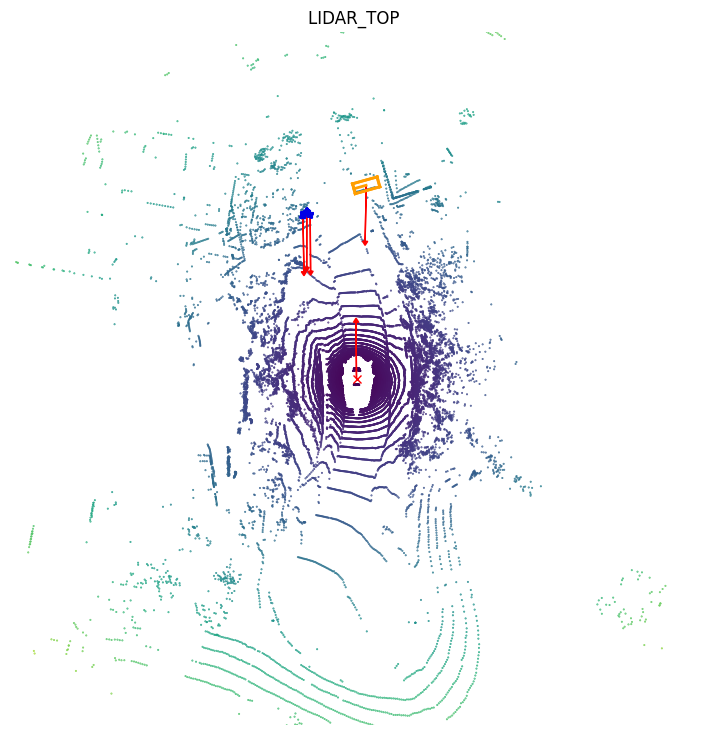

res selections: [0. 0. 0. 0. 0.]
res selections perc: [nan nan nan nan nan]
same_as_heuristic: 0
same_as_heuristic perc: 0.0


/tmp/ipykernel_22836/4191849545.py:135: RuntimeWarning: invalid value encountered in divide
  print('res selections perc:', res_selections / res_selections.sum())


In [67]:
import importlib
importlib.reload(res_pred_utils)

# CONSTANTS
with open('resolution_dataset.pkl', 'rb') as f:
    io_dict = pickle.load(f)
    print(io_dict['fields'])
    io_tuples = io_dict['data']

# Each tuple has: 'coords', 'features', 'resolution', 'sample_tkn'
# remove duplicates first
scores = [tuple(io_tpl[1][:, 6].ravel()) for io_tpl in io_tuples]
mask = np.ones(len(scores), dtype=bool)
scores_set = set()
for i, scr in enumerate(scores):
    if scr in scores_set:
        mask[i] = False
    else:
        scores_set.add(scr)

io_tuples = [io_tpl for m, io_tpl in zip(mask, io_tuples) if m]
print('Number of samples in dataset after removing duplicates:', len(io_tuples))

#NOTE diving by two to make input smaller
# all_coords = [torch.from_numpy(t[0][:, :2]).long() for t in io_tuples]
# cmax = torch.tensor([c.max() for c in all_coords]).max()
# assert cmax < 128
# cmin = torch.tensor([c.min() for c in all_coords]).min()
# assert cmin >= 0
# print('Min and max coords:', cmin, cmax)

res_exec_times_sec = [0.247, 0.147, 0.107, 0.91, 0.77]
# res_exec_times_sec = [0.110, 0.105, 0.100]

use_annos = True
visualize = True
# 750 and 1500 are nice
res_selections = np.zeros(len(res_exec_times_sec))
same_as_heuristic = 0
exec_times = []
for i in range(0, len(io_tuples), 50 if visualize else 1):
    io_tpl = io_tuples[i]
    coords, features, res, sample_tkn = io_tpl

    sample = nusc.get('sample', sample_tkn)

    if not use_annos:
        t1 = time.time()
        scores_mask = features[:, 6] > 0.5
        coords = coords[scores_mask]
        features = features[scores_mask]

        prev_sample_tkn = sample['prev']
        if prev_sample_tkn != '':
            egovel = res_pred_utils.get_2d_egovel(
                                    token_to_ts[prev_sample_tkn],
                                    token_to_pose[prev_sample_tkn],
                                    token_to_ts[sample_tkn],
                                    token_to_pose[sample_tkn])
        else:
            egovel = np.zeros(2)
    
        bboxes = np.zeros((features.shape[0], 9))
        bboxes[:, :2] = coords - 57.6
        # bboxes[:, 3:6] = features[:, :3] * np.array([40., 10., 15.])
        # bboxes[:, 6] = features[:, 3] * 3.14
        bboxes[:, 7:] = features[:, 4:6] * 15.0
        pred_dict = {
            'pred_boxes': torch.from_numpy(bboxes),
            'pred_scores': torch.from_numpy(features[:, 6]).float(),
            'pred_labels': torch.from_numpy(features[:, 7] * 10).int(),
        }
        
        chosen_res = res_pred_utils.pick_best_resolution(res_exec_times_sec, egovel, pred_dict)
        res_selections[chosen_res] += 1
        t2 = time.time()
        exec_times.append(t2-t1)
    
        # print(chosen_res, res)
        same_as_heuristic += (chosen_res == res)
        
        if i % 1000 == 0 and i > 0:
            print('res selections:', res_selections)
            print('res selections perc:', res_selections / res_selections.sum())
            print('Exec time:', round(sum(exec_times)/i * 1000,2), 'ms')

    # if i == 100:
    #     break

    if visualize:
        sample = nusc.get('sample', sample_tkn)
        sensor = 'LIDAR_TOP'
        lidar_data = nusc.get('sample_data', sample['data'][sensor])
        _, ax = plt.subplots(1, 1, figsize=(9, 9))
        nusc.render_sample_data(lidar_data['token'], nsweeps=1, axes_limit=60,
                                use_flat_vehicle_coordinates=False, underlay_map=False,
                                ax=ax, verbose=False)

        if use_annos:
            ep, egovel = res_pred_utils.get_egopose_and_egovel(nusc, sample_tkn)
            cs = nusc.get('calibrated_sensor', lidar_data['calibrated_sensor_token'])
            boxes = nusc.get_boxes(sample['data'][sensor])
            for box in boxes:
                box.velocity = nusc.box_velocity(box.token)
                # Move box to ego vehicle coord system
                box.translate(-np.array(ep['translation']))
                box.rotate(Quaternion(ep['rotation']).inverse)
        
                #  Move box to sensor coord system
                box.translate(-np.array(cs['translation']))
                box.rotate(Quaternion(cs['rotation']).inverse)
            # print(dir(boxes[0]))
            print([b.name for b in boxes])
            coords = [box.center for box in boxes]
            velos = [box.velocity for box in boxes]
        else:
            coords = bboxes[:, :2]
            velos = bboxes[:, 7:9]
        
        for vel, coord in zip(velos, coords):
            # Relative velos
            ax.arrow(coord[0], coord[1], vel[0] - egovel[0], vel[1] - egovel[1],
            #ax.arrow(coord[0], coord[1], vel[0], vel[1],
                 head_width=0.9, head_length=0.7, fc='red', ec='red')
    
        # Egovel
        ax.arrow(0, 0, egovel[0], egovel[1],
                 head_width=0.9, head_length=0.7, fc='red', ec='red')
        
        plt.show()
        break
        input('Waiting user...')
        clear_output()
print('res selections:', res_selections)
print('res selections perc:', res_selections / res_selections.sum())
print('same_as_heuristic:', same_as_heuristic)
print('same_as_heuristic perc:', same_as_heuristic / len(io_tuples))